# Description
A published dataset of net fluxes in molar/hr for strains under different growth rates is used to compare with simulated fluxes and thus compare if the requried flexibility of target reaction matches with measurements

- Simulated fluxes occur at different growth rates and are normalized with respect to substrat uptake rate.

- Measured fluxes are in terms of molar/hr and are not normalized to biomass concentration (or growth rate) However they are normalized to substrate uptake rate (substrate is 100) 

In [21]:
import pandas as pd
import os,sys
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (3, 3),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
df = pd.read_excel('./k-ecoli-data/ncomms13806-s3.xlsx', sheet_name='Flux_Dataset', skiprows=[0,1], usecols="B:AG")
df = df.set_index('Strain')
#df = df/df.values[0,:] # Normalize with respect to growth rate/dilution rate
df = df.iloc[1:] # Drop growth rate/dilution rate row
df.index.name = 'Reaction'
df.head()

,Δpgm,Δpgi,ΔpfkA,ΔpfkB,Δfbp,ΔfbaB,ΔgpmA,ΔgpmB,ΔpykA,ΔpykF,...,wt@aerobic_1,wt@aerobic_2,wt@aerobic_3,wt@aerobic_4,wt@anaer,Δldh@anaer,wt@pyr,Δgnd@pyr,Δzwf@pyr,wt@ac
Reaction,,,,,,,,,,,,,,,,,,,,,
ACALD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.10,0.10,0.00,51.0,63.0,NaN,NaN,NaN,NaN
ACONTa,93.0,67.0,82.0,76.0,82.0,80.0,80.0,104.0,83.0,73.0,...,102.30,83.00,86.16,71.95,NaN,NaN,48.8,46.9,41.8,72.8
AKGDH,74.0,33.0,64.0,43.0,43.0,58.0,64.0,89.0,57.0,34.0,...,92.48,49.72,68.07,39.55,NaN,NaN,45.4,43.3,38.1,49.1
CS,93.0,67.0,82.0,76.0,82.0,80.0,80.0,104.0,83.0,73.0,...,102.30,83.00,86.16,71.95,NaN,NaN,48.8,46.9,41.8,72.8
EX_akg(e),8.0,9.0,9.0,9.0,9.0,9.0,9.0,7.0,9.0,9.0,...,7.40,8.80,8.40,9.00,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
rmap = pd.read_csv('rxnlist_map.csv')
rmap = rmap.dropna(how="any")
paper2model = dict(zip(rmap.paper_id, rmap.model_id))

idx = set(df.index)
common_rxns = idx.intersection(paper2model.keys())
dft = df.loc[common_rxns,:]

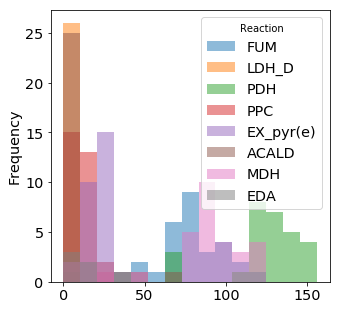

In [49]:
dft.transpose().plot.hist(alpha=0.5, bins=15,figsize=(5,5)) # There are 31 samples, although some reactions are measured more often than others.

In [38]:
def plt_hist(target_rxn, ax, xlims):
    ax = dft.loc[target_rxn,:].plot.hist(alpha=0.5, bins=15, figsize=(3,3),ax=ax, color='gray')
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position('top') 
    ax.yaxis.set_ticks_position('right') 
    ax.yaxis.set_label_position('right') 
    ax.xaxis.set_label_text('Measured fluxes (Molar/hr)', color='gray')
    ax.yaxis.set_label_text('Counts', color='gray')
    ax.tick_params(axis='x', colors='gray')
    ax.tick_params(axis='y', colors='gray')
    #ax.xaxis.set_ticks(xticks*100)
    ax.set_xlim(xlims)

    #plt.savefig('hist-{}.svg'.format(target_rxn), bbox_inches='tight')

In [39]:
# General purpose functions
def get_samples(target_rxn):
    directory='/home/sg/wrk/s/matlab/modcell2-milp-sample-data/samples'
    file_paths = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith(".csv")]
    samples = {}
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            df = pd.read_csv(os.path.join(directory, filename), header=None)
            df.set_index([0], inplace=True)
            if target_rxn in df.index:
                # perform scaling: divide by s.u.r. and then by the maximum value across all networks. 
                samples[filename[:-4]] = (df.loc[target_rxn]/10)
            else:
                # The reaction is blocked for that particular network, usually this reactions are zero but that might not always be true, so their value needs to be read from a file
                samples[filename[:-4]] = 0 # READ FIXED FLUX FILE
    return samples
        
def plot_box(sample,ax):
    #ax.violinplot([v for k,v in sample.items()], vert=True);
    sns.violinplot(data=pd.DataFrame(sample), orient='h',palette=sns.color_palette("husl", 20),ax=ax)
    
id2namedf = pd.read_csv('/home/sg/wrk/s/matlab/modcell2/problems/ecoli-gem/id2name.csv')
id2name = dict(zip(id2namedf['id'],id2namedf['name']))


In [59]:
def plt_pd(target_rxn, ax, negate=False,xlims=None, keeplegend=False):
    print("plotting pd for:", target_rxn )
    sample = get_samples(target_rxn)
    sample = {id2name[k]:v for k,v in sample.items()}

    # Define line styles
    col = sns.color_palette("husl", 10)
    colors = dict(zip(sample.keys(),col+col))
    lines = dict(zip(sample.keys(), ['-']*10 + ['--']*10))

    # Graphing functions
    def plot_target(samples,ax):
        for k,v in samples.items():
            try:
                if negate:
                    v = -v
                sns.distplot(v, hist=False, ax=ax, kde_kws={"color": colors[k], "ls": lines[k]}, label=k)
            except:
                print('production module {} not included due to:{}'.format(k,sys.exc_info()[0])) # e.g. the reaction is always 0


# Generate plot
    #fig, ax = plt.subplots(figsize=[3,3])

    plot_target(sample, ax)

    ax.set_yscale('log')
    ax.set_ylim(bottom=0.01)

    ax.xaxis.set_label_text('Simulated fluxes (mol/mol)'.format(target_rxn))
    ax.yaxis.set_label_text('Probability density')
    #ax.xaxis.set_ticks(xticks)
    ax.set_xlim(xlims)
    #plt.locator_params(axis='both', nbins=4)
    lgd = plt.legend(ncol=5)
    if not keeplegend:
        lgd.remove() # Get rid of legend since it was obtained previously
    #if keeplegend:
    #plt.savefig('legend-{}.svg'.format(target_rxn),bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
target_rxn = 'MDH'
fig, ax = plt.subplots(figsize=[3,3])
plt_pd(target_rxn,ax,None,keeplegend=True)
#plt_hist(target_rxn, ax2)
plt.savefig('legend-{}.svg'.format(target_rxn), bbox_inches='tight')

plotting pd for: MDH


plotting pd for: FUM
production module Propanol not included due to:<class 'TypeError'>
production module 1,4-Butanediol not included due to:<class 'TypeError'>
production module Ethanol not included due to:<class 'TypeError'>
production module Propyl acetate not included due to:<class 'TypeError'>
production module D-Lactate not included due to:<class 'TypeError'>
production module Ethyl butanoate not included due to:<class 'TypeError'>
production module Propyl butanoate not included due to:<class 'TypeError'>
production module Pentanol not included due to:<class 'TypeError'>
production module Isobutyl butanoate not included due to:<class 'TypeError'>
production module Butyl butanoate not included due to:<class 'TypeError'>
production module Isobutanol not included due to:<class 'TypeError'>
production module Butanol not included due to:<class 'TypeError'>
production module Acetate not included due to:<class 'TypeError'>
production module Ethyl acetate not included due to:<class 'Type

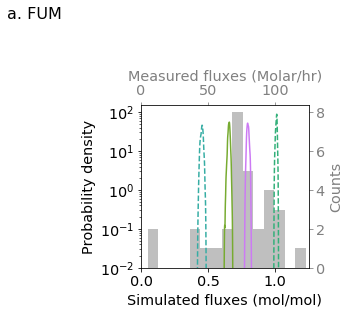

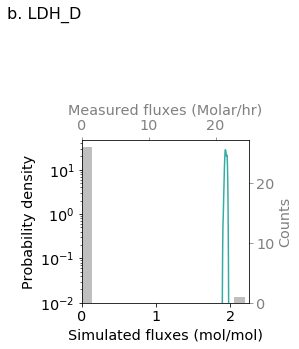

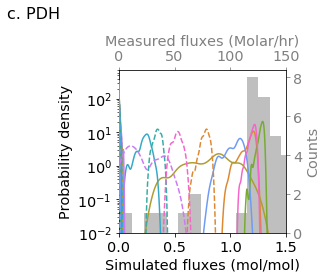

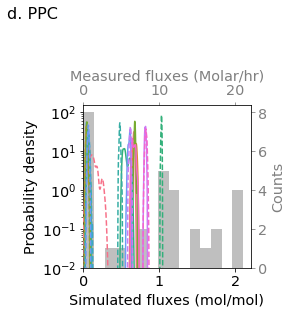

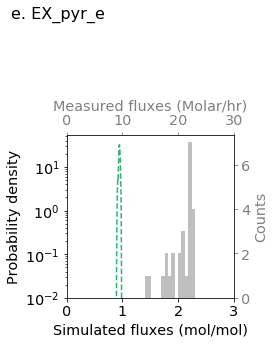

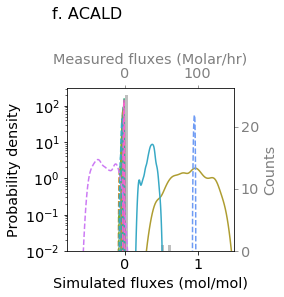

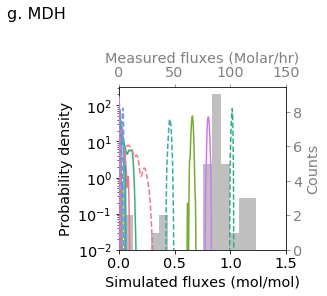

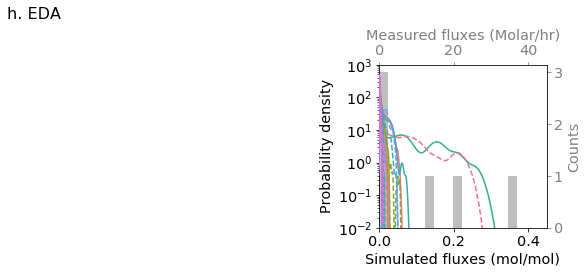

In [50]:
# Cases where the simulated flux is entiery within a negative range they are negated to better overlap with measured fluxes

# TODO: Have axes on same scale by taking maximum of both and adjusting accordingly

negate = {paper2model[rxn]:False for rxn in common_rxns}
negate['FUM'] = True
negate['LDH_D'] = True
negate['MDH'] = True
negate['ACALD'] = True

xlims = {}
xlims['FUM'] = ([0,1.25],[0, 125])
xlims['LDH_D'] = [0,2.25], [0, 25]
xlims['PDH'] = [0,1.5], [0, 150]
xlims['MDH'] = [0,1.5], [0, 150]
xlims['PPC'] = [0,2.2], [0, 22]
xlims['EX_pyr_e'] = [0,3], [0, 30]
xlims['ACALD'] = [-0.8,1.5], [-80, 150]
xlims['EDA'] = [0,0.45], [0, 45]

letters = list('abcdefghijklmnopqrstuvwxyz')
for rxn_paper in list(common_rxns):
    rxn_model = paper2model[rxn_paper]
    #target_rxn = 'PDH'
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)
#plt_hist(target_rxn, ax)
#plt_pd(target_rxn,ax2)
    plt_hist(rxn_paper, ax, xlims[rxn_model][1])
    plt_pd(rxn_model, ax2,negate[rxn_model], xlims[rxn_model][0])
    plt.text(-1,25000,'{}. {}'.format(letters.pop(0),paper2model[rxn_paper]), size=16)
    plt.savefig('{}.svg'.format(paper2model[rxn_paper]), bbox_inches='tight')
